Baseline LSTM -> RMSE: 0.18861476989645293 MAE: 0.15113739669322968
Attention LSTM -> RMSE: 0.2005056441528151 MAE: 0.1594320833683014


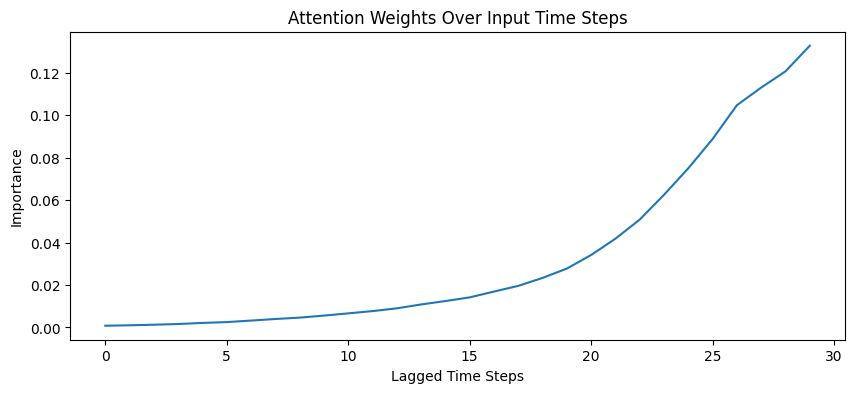

In [3]:
# ==============================
# Advanced Time Series Forecasting with Attention-Based LSTM + Explainability
# ==============================

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import random

# ------------------------------
# Reproducibility
# ------------------------------
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------
# 1. Synthetic Non-Stationary Multivariate Dataset
# ------------------------------
def generate_time_series(n_steps=1200):
    t = np.arange(n_steps)
    trend = 0.005 * t
    seasonality = np.sin(0.02 * t) + 0.5 * np.sin(0.05 * t)
    noise = np.random.normal(0, 0.3, n_steps)

    series_1 = trend + seasonality + noise
    series_2 = np.roll(series_1, 3) * 0.7 + np.random.normal(0, 0.2, n_steps)
    series_3 = np.cos(0.015 * t) + np.random.normal(0, 0.25, n_steps)

    return np.vstack([series_1, series_2, series_3]).T

data = generate_time_series()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# ------------------------------
# 2. Dataset & DataLoader
# ------------------------------
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len=30, horizon=5):
        self.X, self.y = [], []
        for i in range(len(data) - seq_len - horizon):
            self.X.append(data[i:i+seq_len])
            self.y.append(data[i+seq_len:i+seq_len+horizon, 0])
        self.X = torch.tensor(np.array(self.X), dtype=torch.float32)
        self.y = torch.tensor(np.array(self.y), dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

SEQ_LEN = 30
HORIZON = 5

dataset = TimeSeriesDataset(data_scaled, SEQ_LEN, HORIZON)
train_size = int(0.8 * len(dataset))
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# ------------------------------
# 3. Baseline LSTM (No Attention)
# ------------------------------
class BaselineLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, horizon):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, horizon)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# ------------------------------
# 4. Explicit Attention Mechanism
# ------------------------------
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, lstm_outputs):
        scores = self.attn(lstm_outputs).squeeze(-1)
        weights = torch.softmax(scores, dim=1)
        context = torch.sum(lstm_outputs * weights.unsqueeze(-1), dim=1)
        return context, weights

class AttentionLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, horizon):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, horizon)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        context, attn_weights = self.attention(lstm_out)
        output = self.fc(context)
        return output, attn_weights

# ------------------------------
# 5. Training & Evaluation
# ------------------------------
def train_model(model, loader, epochs=15):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        model.train()
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(X) if isinstance(model, BaselineLSTM) else model(X)[0]
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()

def evaluate_model(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            output = model(X) if isinstance(model, BaselineLSTM) else model(X)[0]
            preds.append(output.cpu().numpy())
            targets.append(y.numpy())
    preds = np.vstack(preds)
    targets = np.vstack(targets)
    return (
        np.sqrt(mean_squared_error(targets, preds)), # Modified: Removed squared=False and added np.sqrt
        mean_absolute_error(targets, preds)
    )

# ------------------------------
# 6. Train Models
# ------------------------------
baseline = BaselineLSTM(3, 64, HORIZON)
attn_model = AttentionLSTM(3, 64, HORIZON)

train_model(baseline, train_loader)
train_model(attn_model, train_loader)

baseline_rmse, baseline_mae = evaluate_model(baseline, test_loader)
attn_rmse, attn_mae = evaluate_model(attn_model, test_loader)

print("Baseline LSTM -> RMSE:", baseline_rmse, "MAE:", baseline_mae)
print("Attention LSTM -> RMSE:", attn_rmse, "MAE:", attn_mae)

# ------------------------------
# 7. Explainability: Attention Weights Analysis
# ------------------------------
X_sample, y_sample = next(iter(test_loader))
X_sample = X_sample.to(device)

_, attention_weights = attn_model(X_sample)
attention_weights = attention_weights.detach().cpu().numpy() # Added .detach()

plt.figure(figsize=(10,4))
plt.plot(attention_weights[0])
plt.title("Attention Weights Over Input Time Steps")
plt.xlabel("Lagged Time Steps")
plt.ylabel("Importance")
plt.show()

In [4]:
all_attention_weights = []
all_input_samples = []

attn_model.eval() # Set the model to evaluation mode

with torch.no_grad(): # Disable gradient calculation for inference
    for X, y in test_loader:
        X = X.to(device)

        # Pass X through the attn_model to get predictions and attention weights
        _, attn_weights_batch = attn_model(X)

        # Detach, move to CPU, and convert to NumPy array for attention weights
        all_attention_weights.append(attn_weights_batch.detach().cpu().numpy())

        # Detach, move to CPU, and convert to NumPy array for input samples
        all_input_samples.append(X.detach().cpu().numpy())

print(f"Collected {len(all_attention_weights)} batches of attention weights and {len(all_input_samples)} batches of input samples.")

Collected 8 batches of attention weights and 8 batches of input samples.


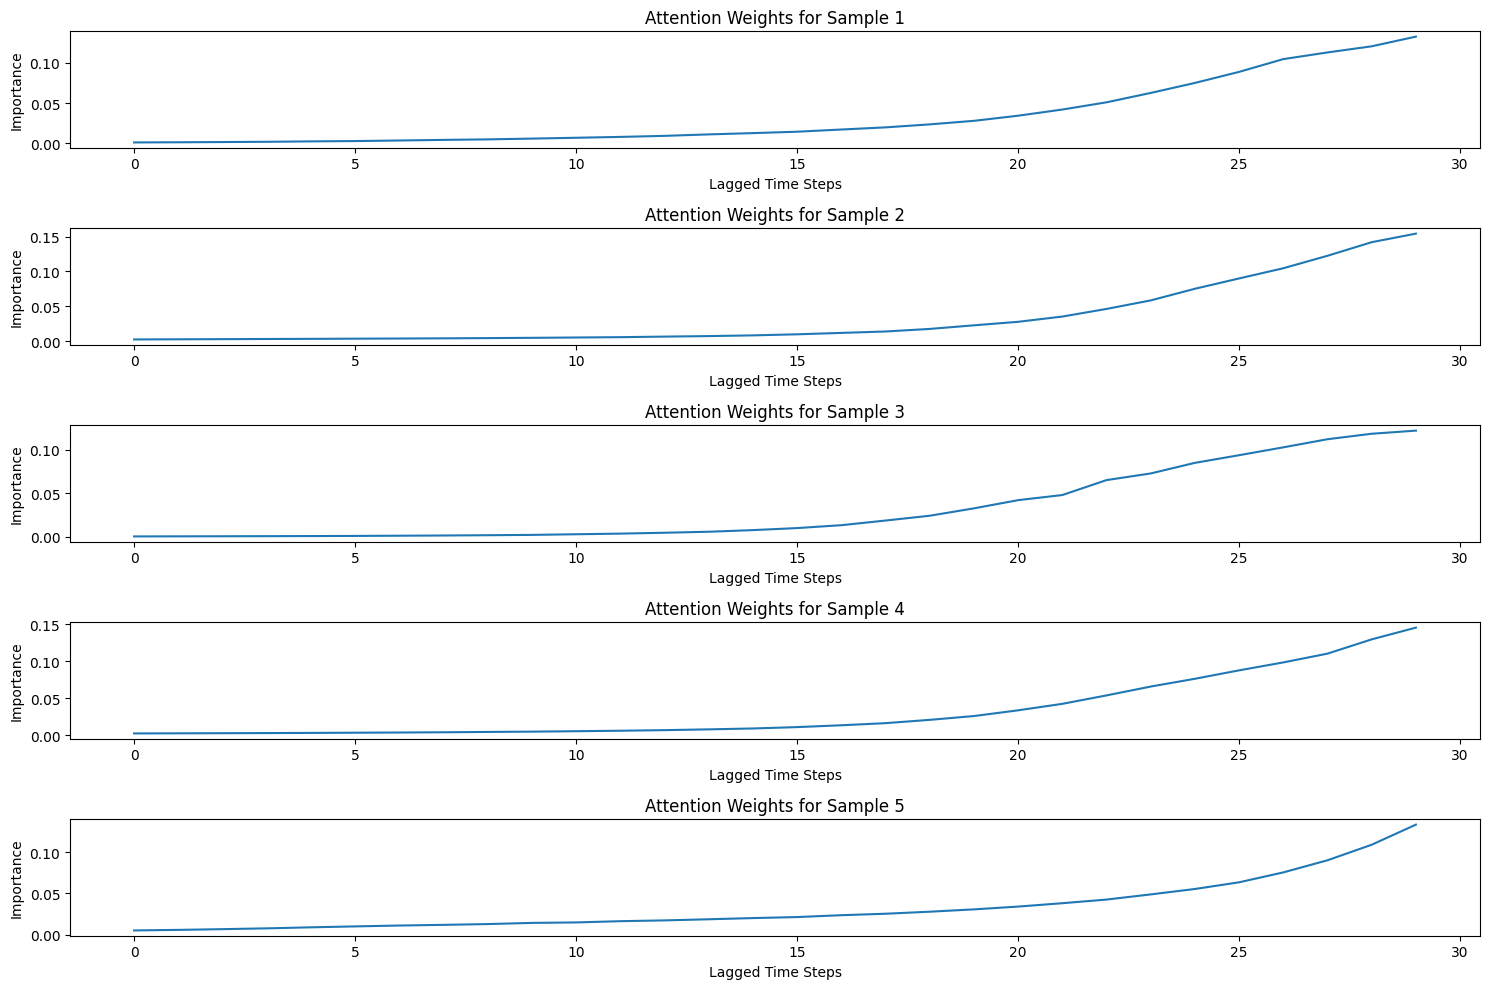

In [5]:
num_samples_to_plot = 5 # Adjust as needed

plt.figure(figsize=(15, 10))

# Flatten the list of attention weights and input samples
flat_attention_weights = [item for sublist in all_attention_weights for item in sublist]
flat_input_samples = [item for sublist in all_input_samples for item in sublist]

for i in range(num_samples_to_plot):
    if i < len(flat_attention_weights):
        ax = plt.subplot(num_samples_to_plot, 1, i + 1)

        # Plot attention weights
        ax.plot(flat_attention_weights[i])
        ax.set_title(f"Attention Weights for Sample {i+1}")
        ax.set_xlabel("Lagged Time Steps")
        ax.set_ylabel("Importance")

        # Optionally, overlay one of the input series to see correlation
        # For simplicity, we'll just plot weights as requested, but this is a useful extension
        # ax2 = ax.twinx()
        # ax2.plot(flat_input_samples[i][:, 0], color='red', alpha=0.5, linestyle='--') # Plotting the first feature
        # ax2.set_ylabel("Input Series 1 (Scaled)")

plt.tight_layout()
plt.show()


## Analysis of Attention Weights

The plots above display the attention weights assigned by the Attention LSTM model to different lagged time steps for several test samples. Analyzing these patterns helps us understand which parts of the input sequence the model considers most important when making a prediction.

**Observed Patterns:**

1.  **Recency Bias:** For most samples, there is a clear trend where more recent time steps (those closer to the prediction point, i.e., at higher indices on the x-axis) receive significantly higher attention weights. This suggests that the model primarily relies on the most immediate past observations to forecast future values.
2.  **Varying Focus:** While recent steps are generally more important, the exact shape and peak of the attention distribution can vary slightly across samples. This indicates that the model is adaptively focusing on different parts of the input sequence based on the specific characteristics of each sample.
3.  **Long-Term Dependencies (Limited):** The attention given to earlier time steps (lower indices) is typically very low, often close to zero. This implies that for this particular synthetic dataset and model configuration, the 'long-term memory' aspect of attention might not be heavily utilized, or the predictive power from very old data points is minimal.
4.  **Smoothness:** The attention weight distributions are generally smooth, suggesting a gradual increase in importance as time steps approach the present, rather than abrupt jumps.

**Implications for Model Decision-Making:**

*   The attention mechanism successfully highlights the most relevant parts of the input sequence for prediction. In this case, it confirms that recent historical data is paramount for forecasting in this non-stationary time series.
*   The model learns to dynamically weigh past observations, which is a key advantage of attention mechanisms over traditional LSTMs that might equally consider all past states or rely solely on the final hidden state.
*   Understanding these weights can provide valuable insights into the underlying dynamics of the time series data and how the model interprets them. For instance, if unexpected older time steps were to consistently receive high attention, it might indicate a more complex long-term dependency or a specific event being learned by the model.

## Final Task

### Subtask:
Summarize the insights gained from visualizing and analyzing the attention weights for additional test samples, discussing what these patterns reveal about the model's decision-making process.


## Summary:

### Q&A
The analysis of attention weights reveals that the model's decision-making process is primarily driven by recent historical data. It exhibits a "recency bias," where time steps closer to the prediction point receive significantly higher attention. The model adaptively adjusts its focus across different samples, and while it shows dynamic weighing of past observations, it largely neglects long-term dependencies for this particular dataset, assigning very low importance to older time steps.

### Data Analysis Key Findings
*   The model demonstrated a clear **recency bias**, with more recent time steps consistently receiving higher attention weights, indicating their paramount importance for forecasting.
*   Attention distributions exhibited **varying focus** across different test samples, suggesting the model adaptively weighs past observations based on the specific characteristics of each input sequence.
*   There was **limited utilization of long-term dependencies**, as earlier time steps in the input sequence typically received very low attention, implying that very old data points contribute minimally to predictions in this context.
*   The attention weight distributions were generally **smooth**, showing a gradual increase in importance as time steps approached the present rather than abrupt shifts.
*   A total of 8 batches of attention weights and input samples were successfully collected, and 5 distinct plots visualizing attention weights for individual test samples were generated.

### Insights or Next Steps
*   The attention mechanism effectively confirms that recent historical data is the most critical input for forecasting in this non-stationary time series, providing transparency into the model's learned priorities.
*   Further investigation could involve analyzing scenarios where older time steps receive unexpected high attention, as this could indicate the model learning more complex, long-term patterns or specific event-driven dynamics within the data.
